# Generate EKF C-code from Dynamic System Model

In [19]:
# Generate and Compile C Code
%run generate_ekf.py

import os
import subprocess
import ctypes
import numpy as np
import importlib
importlib.reload(ctypes)
importlib.reload(subprocess)

# Compile C code and create library

# https://cu7ious.medium.com/how-to-use-dynamic-libraries-in-c-46a0f9b98270
path = os.path.abspath('c_code')
# Remove old library
subprocess.call('rm -f *.so', shell=True, cwd=path)
subprocess.call('rm -f *.o', shell=True, cwd=path)
# Compile object files
subprocess.call('gcc -fPIC -c *.c common/*.c -Icommon', shell=True, cwd=path)
# Create library
subprocess.call('gcc -shared -Wl,-soname,libtools.so -o libtools.so *.o', shell=True, cwd=path)
# Remove object files
# subprocess.call('rm *.o', shell=True, cwd=path)

lib_path = os.path.abspath("c_code/libtools.so")
lib = ctypes.CDLL(lib_path)

# define argument types 
lib.ekf_set_Q.argtypes = [ctypes.POINTER(ctypes.c_float)]
lib.ekf_set_R_mocap.argtypes = [ctypes.POINTER(ctypes.c_float)]
lib.ekf_set_R_vbody.argtypes = [ctypes.POINTER(ctypes.c_float)]
lib.ekf_set_X.argtypes = [ctypes.POINTER(ctypes.c_float)]
lib.ekf_set_P_diag.argtypes = [ctypes.POINTER(ctypes.c_float)]

lib.ekf_get_X.restype = ctypes.POINTER(ctypes.c_float)
lib.ekf_get_P.restype = ctypes.POINTER(ctypes.c_float)

lib.ekf_predict.argtypes = [ctypes.POINTER(ctypes.c_float), ctypes.c_float]
lib.ekf_update_mocap.argtypes = [ctypes.POINTER(ctypes.c_float)]
lib.ekf_update_vbody.argtypes = [ctypes.POINTER(ctypes.c_float)]

# ekf_use_quat = ctypes.c_bool.in_dll(lib, "ekf_use_quat")

PREDICTION:
CSE
SIMPLIFY
CCODE
S and PHT MATRICES FOR SOLVING K:
CSE
SIMPLIFY
CCODE
UPDATE:
CSE
SIMPLIFY
CCODE
S and PHT MATRICES FOR SOLVING K:
CSE
SIMPLIFY
CCODE
UPDATE:
CSE
SIMPLIFY
CCODE


<Figure size 640x480 with 0 Axes>

# Test C code

In [20]:
import matplotlib.pyplot as plt
from analyze import *

#data = np.load('ekf_data_6may_8ms_delay.npz')
data = load_flight_data('Okt10_NN_long_oval_2.csv')

# optitrack frequency
opti_updates = (np.gradient(data['x_opti'])!=0) | (np.gradient(data['y_opti'])!=0) | (np.gradient(data['z_opti'])!=0)
opti_freq = 1/np.mean(np.diff(data['t'][opti_updates]))
print('optitrack frequency:',opti_freq,'Hz')

data = trim_nn_active(data)
data = trim_time(data, 0, 10)
animate_data_multiple2(data)

Loading Okt10_NN_long_oval_2.csv
Logging frequency: 808.4233029186809
optitrack frequency: 32.862846908427684 Hz


QObject::moveToThread: Current thread (0x5596771b3400) is not the object's thread (0x559676a29390).
Cannot move to target thread (0x5596771b3400)

QObject::moveToThread: Current thread (0x5596771b3400) is not the object's thread (0x559676a29390).
Cannot move to target thread (0x5596771b3400)

QObject::moveToThread: Current thread (0x5596771b3400) is not the object's thread (0x559676a29390).
Cannot move to target thread (0x5596771b3400)

QObject::moveToThread: Current thread (0x5596771b3400) is not the object's thread (0x559676a29390).
Cannot move to target thread (0x5596771b3400)

QObject::moveToThread: Current thread (0x5596771b3400) is not the object's thread (0x559676a29390).
Cannot move to target thread (0x5596771b3400)

QObject::moveToThread: Current thread (0x5596771b3400) is not the object's thread (0x559676a29390).
Cannot move to target thread (0x5596771b3400)

QObject::moveToThread: Current thread (0x5596771b3400) is not the object's thread (0x559676a29390).
Cannot move to tar

fitting thrust and drag model


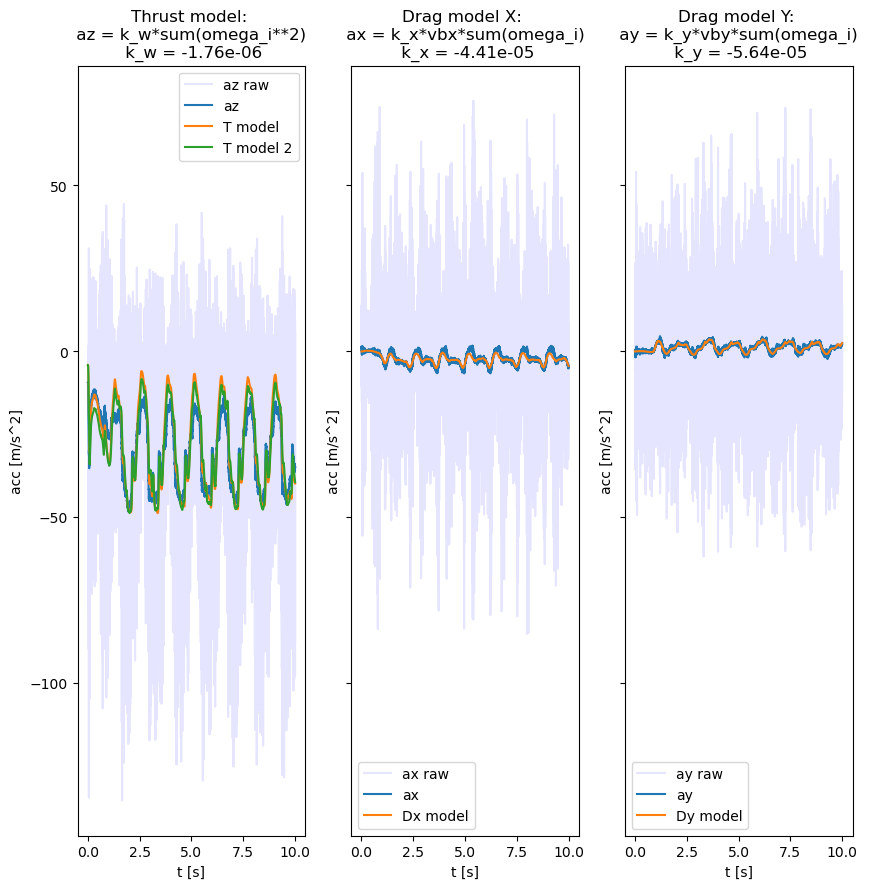

(np.float64(-1.760787661495768e-06),
 np.float64(-4.4101352886986136e-05),
 np.float64(-5.637960835110806e-05))

In [21]:
fit_thrust_drag_model(data)

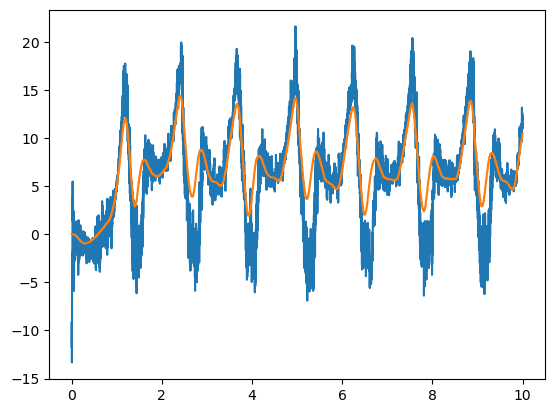

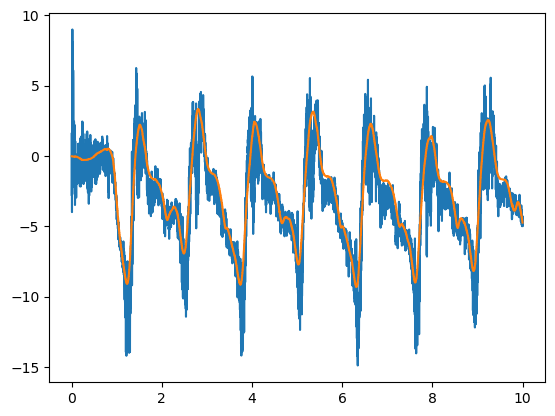

In [22]:
k_x = -4.41e-5
k_y = -5.64e-5
wsum = data['omega[0]']+data['omega[1]']+data['omega[2]']+data['omega[3]']
# ax = k_x*wsum*vbx --> vbx = ax/(k_x*wsum)
# ay = k_y*wsum*vby --> vby = ay/(k_y*wsum)
vbx_estimate = data['ax']/(k_x*wsum)
vby_estimate = data['ay']/(k_y*wsum)

data['vbx_estimate'] = vbx_estimate
data['vby_estimate'] = vby_estimate

plt.plot(data['t'], data['vbx_estimate'], label='vbx estimate')
plt.plot(data['t'], data['vbx'], label='vbx')
plt.show()

plt.plot(data['t'], data['vby_estimate'], label='vby estimate')
plt.plot(data['t'], data['vby'], label='vby')
plt.show()


In [23]:
# EKF INPUT: U = [ax, ay, az, p, q, r] (IMU)
U_data = np.array([
    data['ax'], data['ay'], data['az'], data['p'], data['q'], data['r']
]).T

# EKF MEASUREMENT MOCAP: Z = [x, y, z, qw, qx, qy, qz] (Optitrack)
Z_data_mocap = np.array([
    data['x_opti'], data['y_opti'], data['z_opti'], 1*data['qw_opti'], 10000*data['qx_opti'], 1*data['qy_opti'], data['qz_opti']
]).T
# EKF MEASUREMENT VBODY Z = [vbx, vby]
Z_data_vbody = np.array([data['vbx_estimate'], data['vby_estimate']]).T
# Z_data_vbody = np.array([data['vbx'], data['vby']]).T

t = data['t']

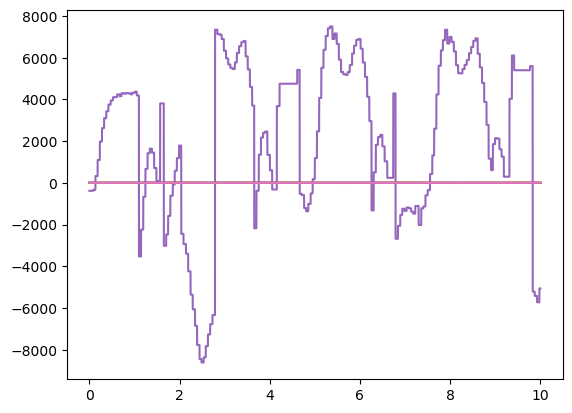

In [24]:
plt.plot(t, Z_data_mocap[:,0], label='x')
plt.plot(t, Z_data_mocap[:,1], label='y')
plt.plot(t, Z_data_mocap[:,2], label='z')
plt.plot(t, Z_data_mocap[:,3], label='qw')
plt.plot(t, Z_data_mocap[:,4], label='qx')
plt.plot(t, Z_data_mocap[:,5], label='qy')
plt.plot(t, Z_data_mocap[:,6], label='qz')

In [25]:
# INITIALIZE EKF
# initial state
lenX = 16
X_init = np.zeros(lenX)
X_init[:3] = Z_data_mocap[0,:3]
a = -72. * np.pi / 180.
X_init[6] = np.cos(0.5*a)
X_init[7] = 0.0
X_init[8] = 0.0
X_init[9] = np.sin(0.5*a)
X_init[6:10] = Z_data_mocap[0,3:7]
# X_init[12:15] = [p_bias, q_bias, r_bias]
# ekf_use_quat.value = False

# initial covariance
P_init = np.array([1.]*lenX)
#P_init[9] = 10. # initial heading covarinace
P_init[-6:-3] = 1e-2 # set accel bias covariance
P_init[-3:] = 0#1e-2 # set gyro bias covariance. 
# P_init[-3:] *= (ekf_use_quat.value) # do not estimate bias if no heading measurement
# print(P_init)

# process noise covariance
# Q_diag = np.array([0.5, 0.5, 0.5, 0.01, 0.01, 0.01, 1e-5, 1e-5, 1e-5, 0, 0, 0])
Q_diag = np.array([0.5, 0.5, 0.5, 0.1, 0.1, 0.1, 1e-4, 1e-4, 1e-4, 1e-5, 1e-5, 1e-5])
# Q_diag[-3:] *= (ekf_use_quat.value)

# measurement noise covariance MOCAP
R_diag_mocap = np.array([0.005, 0.005, 0.005, .05, .05, .05, .05])
# measurement noise covariance VBODY
R_diag_vbody = np.array([100000., 100000.])

lib.ekf_set_Q((ctypes.c_float*len(Q_diag))(*Q_diag))
lib.ekf_set_R_mocap((ctypes.c_float*len(R_diag_mocap))(*R_diag_mocap))
lib.ekf_set_R_vbody((ctypes.c_float*len(R_diag_vbody))(*R_diag_vbody))
lib.ekf_set_X((ctypes.c_float*len(X_init))(*X_init))
lib.ekf_set_P_diag((ctypes.c_float*len(P_init))(*P_init))

# test ekf_get_state
x = lib.ekf_get_X()
x = np.array([x[i] for i in range(lenX)])
print(x)

# RUN EKF
X_ekf = [X_init]
P_ekf = [np.array([1.])*int(lenX*(lenX+1)/2)]

X_sampled = []
X_delayed = []
X_shift =[]
m_idx =[]

# start with N mocap updates to converge more
N = 100
for i in range(N):
    # update
    lib.ekf_update_mocap(
        (ctypes.c_float*len(Z_data_mocap[0]))(*Z_data_mocap[0])
    )

for i in range(1, len(t)):
    # PREDICT
    lib.ekf_predict(
        (ctypes.c_float*len(U_data[i]))(*U_data[i]),
        ctypes.c_float(t[i]-t[i-1])
    )
    
    # UPDATE MOCAP
    # only update when there is a new measurement
    if np.any(Z_data_mocap[i]-Z_data_mocap[i-1] != 0):
        m_idx.append(i)
        
        # update
        lib.ekf_update_mocap(
            (ctypes.c_float*len(Z_data_mocap[i]))(*Z_data_mocap[i])
        )
        
    # UPDATE VBODY
    # only update when there is a new measurement
    # if np.any(Z_data_vbody[i]-Z_data_vbody[i-1] != 0):
        # update
        # lib.ekf_update_vbody(
        #     (ctypes.c_float*len(Z_data_vbody[i]))(*Z_data_vbody[i])
        # )
        
    # get state
    x = lib.ekf_get_X()
    x = np.array([x[i] for i in range(lenX)])
    X_ekf.append(x)
    
    # get Pdiag
    P = lib.ekf_get_P()
    P = np.array([P[i] for i in range(int(lenX*(lenX+1)/2))])
    P_ekf.append(P)
    #print(P[[int(i*(i+1)/2 + i) for i in range(13,16)]])


[ 1.51699996e+00 -6.83199978e+00 -8.79999995e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  6.83770120e-01 -3.80214111e+02
  5.02030253e-02  7.26959527e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]


In [26]:
X_ekf_corrected =  np.array(X_ekf)
X_ekf_normal = np.array(X_ekf)
X_ekf_Zshift = np.array(X_ekf)

Using matplotlib backend: module://matplotlib_inline.backend_inline


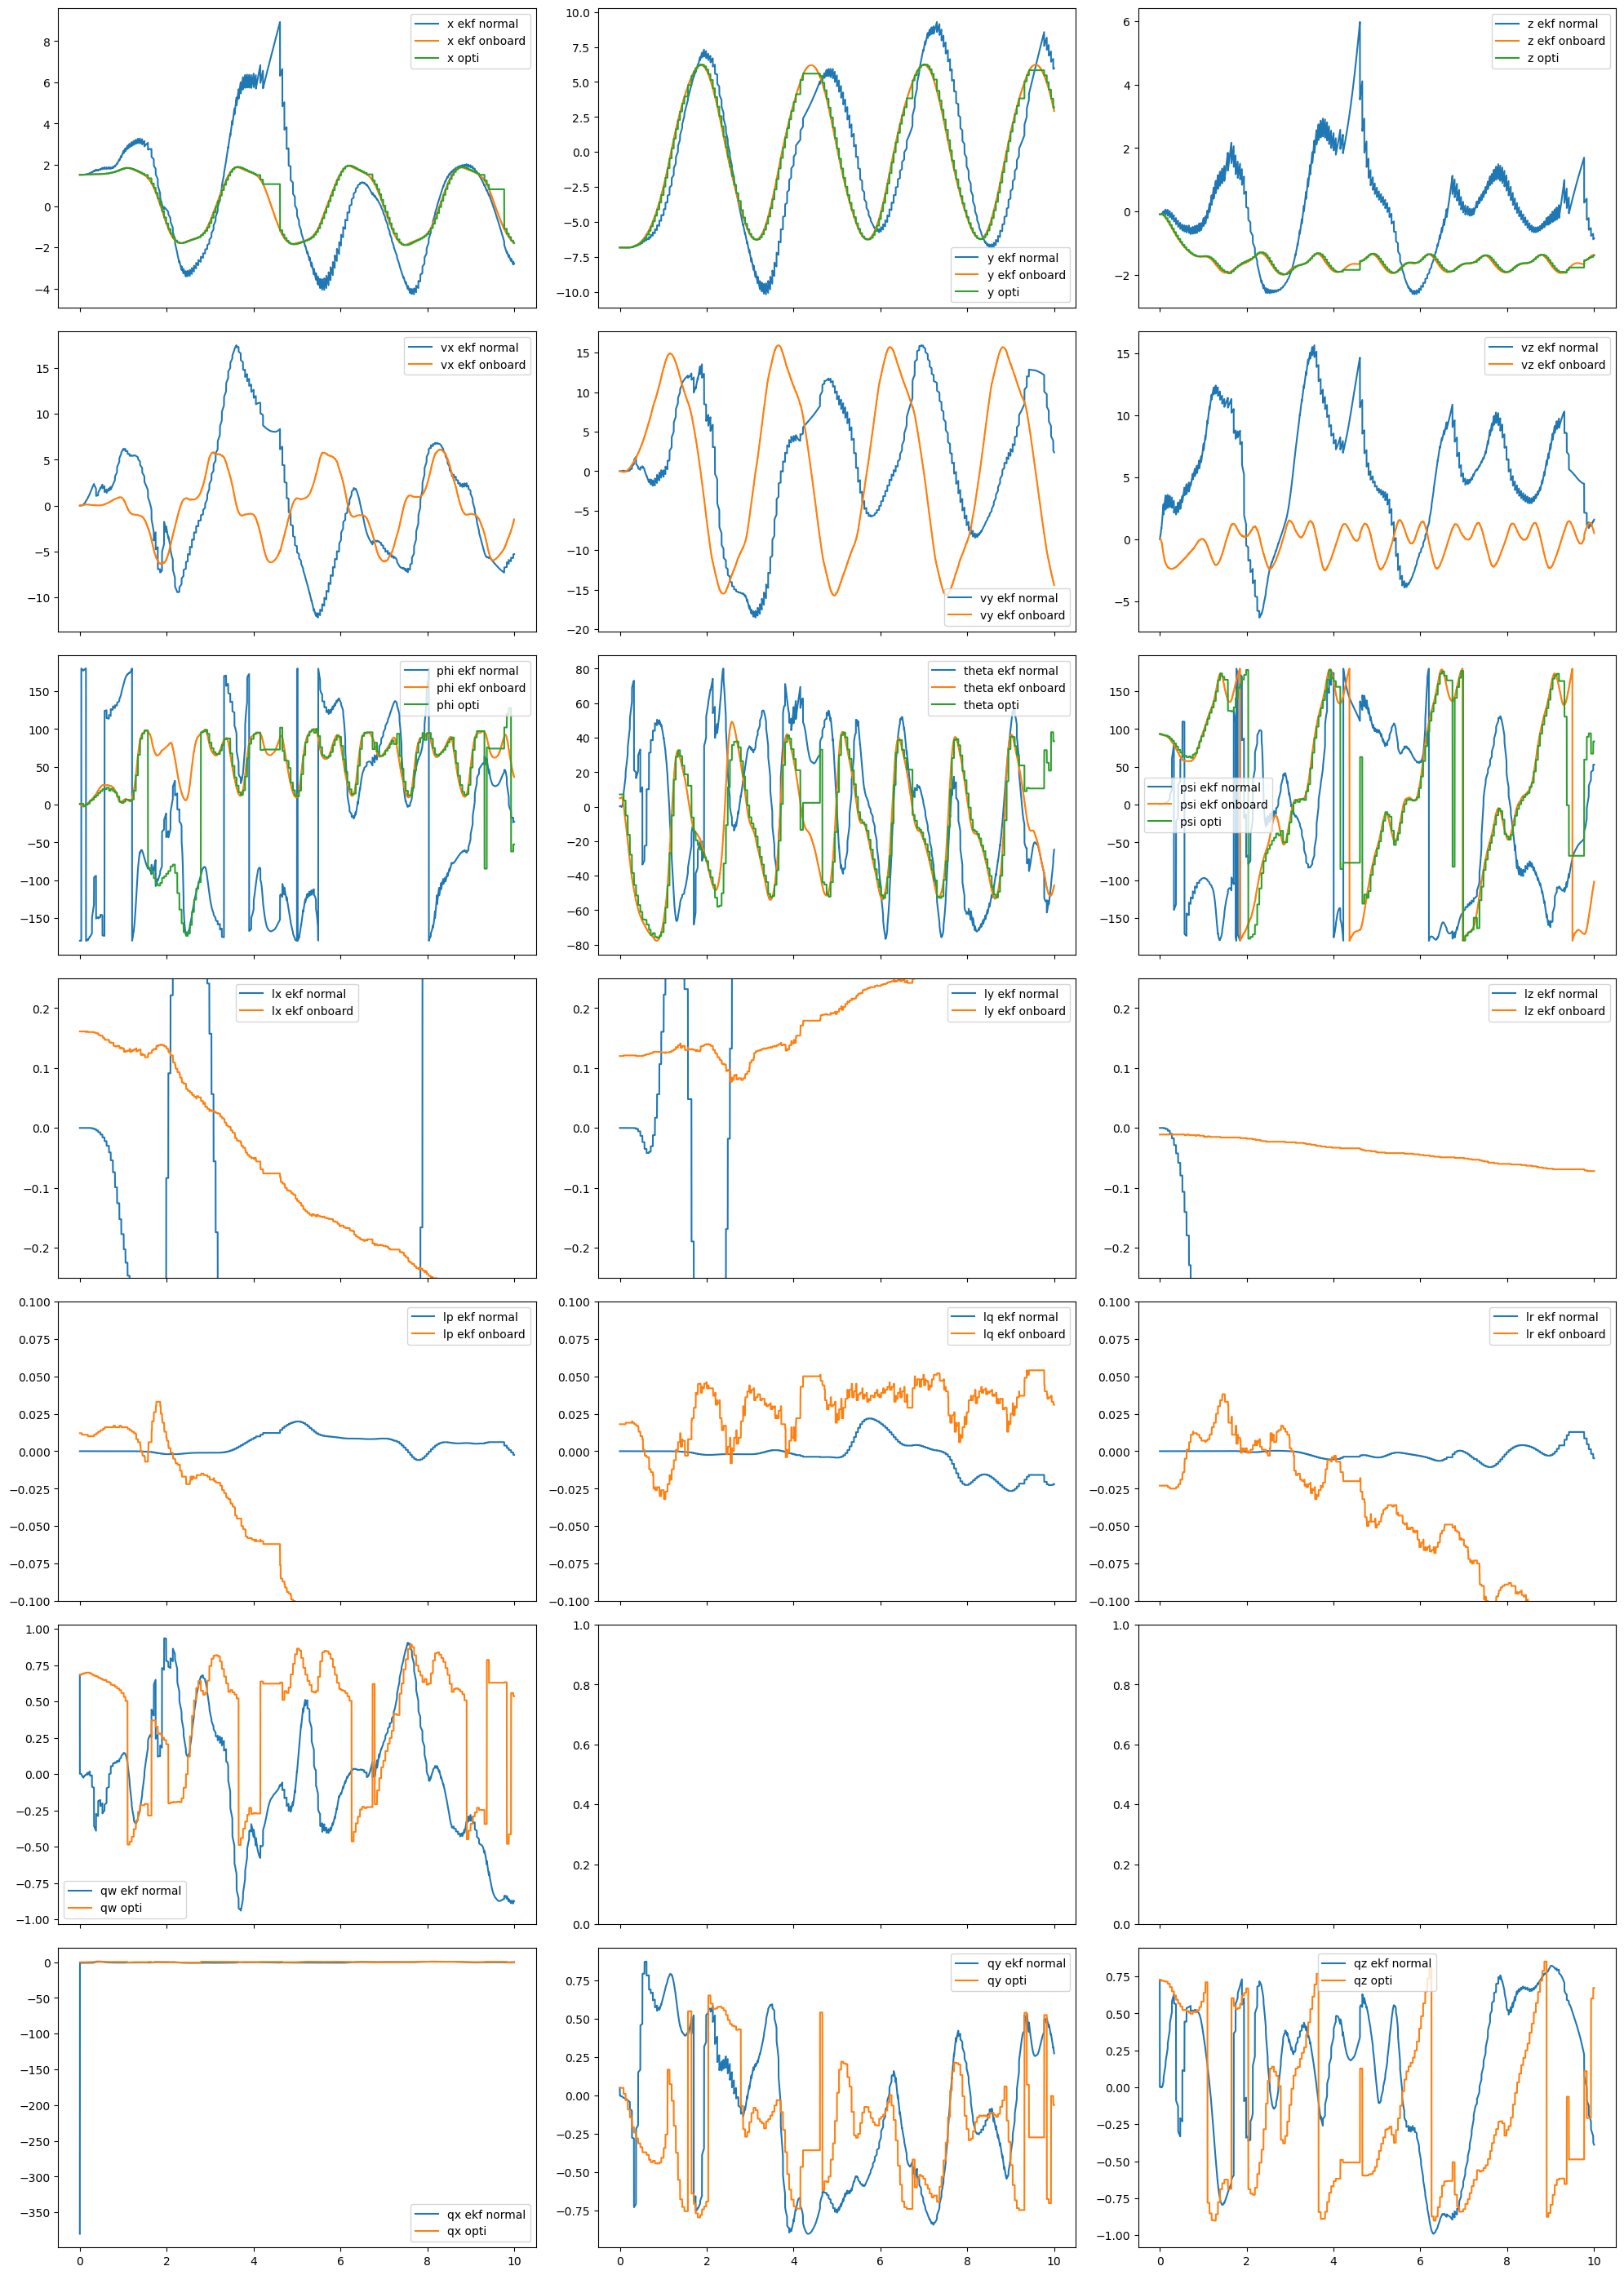

In [27]:
# plot trajectory
%matplotlib
X_ekf = np.array(X_ekf)
# Pdiag_ekf = np.array(Pdiag_ekf)


# 5x3 subplots
fig, axs = plt.subplots(7, 3, figsize=(20,7/5*20), tight_layout=True, sharex=True)
axs = axs.flatten()

# position
axs[0].plot(t, X_ekf_normal[:,0], label='x ekf normal')
# axs[0].plot(t, X_ekf_Zshift[:,0], label='x ekf Zshift')
# axs[0].plot(t, X_ekf_corrected[:,0], label='x ekf corrected')
axs[0].plot(t, data['ekf_x'], label='x ekf onboard')
axs[0].plot(t, data['x_opti'], label='x opti')
axs[0].legend()


axs[1].plot(t, X_ekf_normal[:,1], label='y ekf normal')
# axs[1].plot(t, X_ekf_Zshift[:,1], label='y ekf Zshift')
# axs[1].plot(t, X_ekf_corrected[:,1], label='y ekf corrected')
axs[1].plot(t, data['ekf_y'], label='y ekf onboard')
axs[1].plot(t, data['y_opti'], label='y opti')
axs[1].legend()

axs[2].plot(t, X_ekf_normal[:,2], label='z ekf normal')
# axs[2].plot(t, X_ekf_Zshift[:,2], label='z ekf Zshift')
# axs[2].plot(t, X_ekf_corrected[:,2], label='z ekf corrected')
axs[2].plot(t, data['ekf_z'], label='z ekf onboard')
axs[2].plot(t, data['z_opti'], label='z opti')
axs[2].legend()

# velocity
axs[3].plot(t, X_ekf_normal[:,3], label='vx ekf normal')
# axs[3].plot(t, X_ekf_Zshift[:,3], label='vx ekf Zshift')
# axs[3].plot(t, X_ekf_corrected[:,3], label='vx ekf corrected')
axs[3].plot(t, data['ekf_vx'], label='vx ekf onboard')
axs[3].legend()

axs[4].plot(t, X_ekf_normal[:,4], label='vy ekf normal')
# axs[4].plot(t, X_ekf_Zshift[:,4], label='vy ekf Zshift')
# axs[4].plot(t, X_ekf_corrected[:,4], label='vy ekf corrected')
axs[4].plot(t, data['ekf_vy'], label='vy ekf onboard')
axs[4].legend()

axs[5].plot(t, X_ekf_normal[:,5], label='vz ekf normal')
# axs[5].plot(t, X_ekf_Zshift[:,5], label='vz ekf Zshift')
# axs[5].plot(t, X_ekf_corrected[:,5], label='vz ekf corrected')
axs[5].plot(t, data['ekf_vz'], label='vz ekf onboard')
axs[5].legend()

# attitude
rad_to_deg = 180/np.pi
from scipy.spatial.transform import Rotation
eulers = Rotation.from_quat(X_ekf_normal[:, [7, 8, 9, 6]]).as_euler('xyz', degrees=False)
# eulers = np.zeros_like(X_ekf_normal[:, [6, 7, 8]])

axs[6].plot(t, rad_to_deg*eulers[:,0], label='phi ekf normal')
# axs[6].plot(t, rad_to_deg*X_ekf_Zshift[:,6], label='phi ekf Zshift')
# axs[6].plot(t, rad_to_deg*X_ekf_corrected[:,6], label='phi ekf corrected')
axs[6].plot(t, rad_to_deg*data['ekf_phi'], label='phi ekf onboard')
axs[6].plot(t, rad_to_deg*data['phi_opti'], label='phi opti')
axs[6].legend()

axs[7].plot(t, rad_to_deg*eulers[:,1], label='theta ekf normal')
# axs[7].plot(t, rad_to_deg*X_ekf_Zshift[:,7], label='theta ekf Zshift')
# axs[7].plot(t, rad_to_deg*X_ekf_corrected[:,7], label='theta ekf corrected')
axs[7].plot(t, rad_to_deg*data['ekf_theta'], label='theta ekf onboard')
axs[7].plot(t, rad_to_deg*data['theta_opti'], label='theta opti')
axs[7].legend()

axs[8].plot(t, rad_to_deg*eulers[:,2], label='psi ekf normal')
# axs[8].plot(t, rad_to_deg*X_ekf_Zshift[:,8], label='psi ekf Zshift')
# axs[8].plot(t, rad_to_deg*X_ekf_corrected[:,8], label='psi ekf corrected')
axs[8].plot(t, rad_to_deg*data['ekf_psi'], label='psi ekf onboard')
axs[8].plot(t, rad_to_deg*data['psi_opti'], label='psi opti')
axs[8].legend()

# biases
axs[9].plot(t, X_ekf_normal[:,10], label='lx ekf normal')
# axs[9].plot(t, X_ekf_Zshift[:,9], label='lx ekf Zshift')
# axs[9].plot(t, X_ekf_corrected[:,9], label='lx ekf corrected')
axs[9].plot(t, data['ekf_acc_b_x'], label='lx ekf onboard')
axs[9].set_ylim([-0.25, 0.25])
axs[9].legend()

axs[10].plot(t, X_ekf_normal[:,11], label='ly ekf normal')
# axs[10].plot(t, X_ekf_Zshift[:,10], label='ly ekf Zshift')
# axs[10].plot(t, X_ekf_corrected[:,10], label='ly ekf corrected')
axs[10].plot(t, data['ekf_acc_b_y'], label='ly ekf onboard')
axs[10].set_ylim([-0.25, 0.25])
axs[10].legend()

axs[11].plot(t, X_ekf_normal[:,12], label='lz ekf normal')
# axs[11].plot(t, X_ekf_Zshift[:,11], label='lz ekf Zshift')
# axs[11].plot(t, X_ekf_corrected[:,11], label='lz ekf corrected')
axs[11].plot(t, data['ekf_acc_b_z'], label='lz ekf onboard')
axs[11].set_ylim([-0.25, 0.25])
axs[11].legend()

axs[12].plot(t, rad_to_deg*X_ekf_normal[:,13], label='lp ekf normal')
# axs[12].plot(t, rad_to_deg*X_ekf_Zshift[:,12], label='lp ekf Zshift')
# axs[12].plot(t, rad_to_deg*X_ekf_corrected[:,12], label='lp ekf corrected')
axs[12].plot(t, rad_to_deg*data['ekf_gyro_b_x'], label='lp ekf onboard')
axs[12].set_ylim([-0.1, 0.1])
axs[12].legend()

axs[13].plot(t, rad_to_deg*X_ekf_normal[:,14], label='lq ekf normal')
# axs[13].plot(t, rad_to_deg*X_ekf_Zshift[:,13], label='lq ekf Zshift')
# axs[13].plot(t, rad_to_deg*X_ekf_corrected[:,13], label='lq ekf corrected')
axs[13].plot(t, rad_to_deg*data['ekf_gyro_b_y'], label='lq ekf onboard')
axs[13].set_ylim([-0.1, 0.1])
axs[13].legend()

axs[14].plot(t, rad_to_deg*X_ekf_normal[:,15], label='lr ekf normal')
# axs[14].plot(t, rad_to_deg*X_ekf_Zshift[:,14], label='lr ekf Zshift')
# axs[14].plot(t, rad_to_deg*X_ekf_corrected[:,14], label='lr ekf corrected')
axs[14].plot(t, rad_to_deg*data['ekf_gyro_b_z'], label='lr ekf onboard')
axs[14].set_ylim([-0.1, 0.1])
axs[14].legend()

axs[15].plot(t, X_ekf_normal[:,6], label='qw ekf normal')
#axs[15].plot(t, rad_to_deg*data['ekf_gyro_b_z'], label='qw ekf onboard')
axs[15].plot(t, data['qw_opti'], label='qw opti')
axs[15].legend()

axs[18].plot(t, X_ekf_normal[:,7], label='qx ekf normal')
#axs[18].plot(t, rad_to_deg*data['ekf_gyro_b_z'], label='qx ekf onboard')
axs[18].plot(t, data['qx_opti'], label='qx opti')
axs[18].legend()

axs[19].plot(t, X_ekf_normal[:,8], label='qy ekf normal')
#axs[19].plot(t, rad_to_deg*data['ekf_gyro_b_z'], label='qy ekf onboard')
axs[19].plot(t, data['qy_opti'], label='qy opti')
axs[19].legend()

axs[20].plot(t, X_ekf_normal[:,9], label='qz ekf normal')
#axs[20].plot(t, rad_to_deg*data['ekf_gyro_b_z'], label='qz ekf onboard')
axs[20].plot(t, data['qz_opti'], label='qz opti')
axs[20].legend()

plt.show()

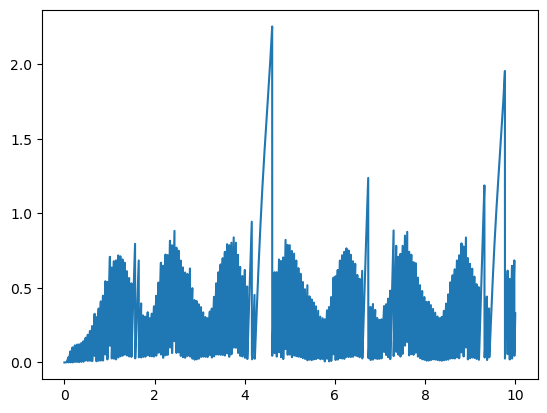

In [17]:
drift = X_ekf_normal[:,0:3]-Z_data_mocap[:,0:3]
drift_dist = np.linalg.norm(drift, axis=1)
plt.plot(data['t'], drift_dist)

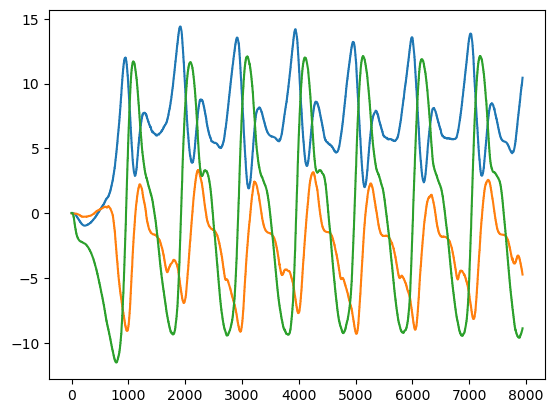

In [12]:
plt.plot(data['vbx'])
plt.plot(data['vby'])
plt.plot(data['vbz'])